In [1]:
# import cudf as pd
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# df = pd.read_csv("llamacpp.llama8b.trace.1717666638-4conversation.log")
df = pd.read_csv("llamacpp.llama8b.trace.1717668900-no_cache_drop.log")
df = df.dropna()

/tmp/ipykernel_3300694/2695831885.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("llamacpp.llama8b.trace.1717668900-no_cache_drop.log")


In [3]:
df['time'] = df["time"].astype("int")
df["error_code"] = df["error_code"].astype("int").parallel_apply(lambda x: bin(x)[2:])

In [4]:
df["name"].value_counts()

name
node               2048224
loginctl           1460583
main                655767
sh                  283863
ps                  198896
cpptools-srv        166639
grep                103192
cpptools            101427
cpuUsage.sh          43745
nft                  37839
cat                  17802
watch                 8256
rustdesk              5327
sed                   5007
which                 2824
systemd-journal       2719
sleep                 1597
cuda-EvtHandlr        1018
sudo                   614
dbus-daemon            598
clash                  565
gdbus                  442
zsh                    196
bash                   103
bpftrace                61
sshd                    55
in:imklog               53
rs:main Q:Reg           49
polkitd                 24
in:imuxsock             24
tokio-runtime-w         14
dmesg                   12
rshim                   11
flexi_logger-fl          7
flexi_logger-fs          5
gitstatusd-linu          5
pool-tracker-mi        

In [5]:
# 过滤掉其他附带的程序
df = df[df["name"] == "main"]
df = df.reset_index().drop(columns=["index"])

In [6]:
df["name"].value_counts()

name
main    655767
Name: count, dtype: int64

In [7]:
df

,pid,name,addr,error_code,instruction_ptr,time
0,3267035,main,0x7f1e954b0290,10100,0x7f1e954b0290,6669165371945734
1,3267035,main,0x7f1e954cae0e,110,0x7f1e954b1055,6669165371950564
2,3267035,main,0x7f1e954c9aa0,110,0x7f1e954b1071,6669165371954264
3,3267035,main,0x7f1e9549d990,10100,0x7f1e9549d990,6669165371983743
4,3267035,main,0x559301dd6040,100,0x7f1e954b2330,6669165371988253
...,...,...,...,...,...,...
655762,3267035,main,0x7f1ceefc89b8,110,0x7f1e8bf26a3e,6669257831172381
655763,3267035,main,0x5593053f6a40,100,0x7f1e8be7f141,6669257970466811
655764,3267035,main,0x7ffc1cbe4300,110,0x7f1e8be775bb,6669260317937751
655765,3267035,main,0x7ffc1cbe3c68,110,0x7f1e8be75048,6669260317950731


# 虚拟地址转换成pfn

In [8]:
df["pfn"] = df["addr"].apply(lambda x: int(x, 16))
df["pfn"] = df["pfn"].parallel_apply(lambda x: (x - df["pfn"].min()) // (4 * 1024))
df["pfn"] = df["pfn"].astype("int")

In [9]:
df

,pid,name,addr,error_code,instruction_ptr,time,pfn
0,3267035,main,0x7f1e954b0290,10100,0x7f1e954b0290,6669165371945734,11152209626
1,3267035,main,0x7f1e954cae0e,110,0x7f1e954b1055,6669165371950564,11152209652
2,3267035,main,0x7f1e954c9aa0,110,0x7f1e954b1071,6669165371954264,11152209651
3,3267035,main,0x7f1e9549d990,10100,0x7f1e9549d990,6669165371983743,11152209607
4,3267035,main,0x559301dd6040,100,0x7f1e954b2330,6669165371988253,0
...,...,...,...,...,...,...,...
655762,3267035,main,0x7f1ceefc89b8,110,0x7f1e8bf26a3e,6669257831172381,11150479858
655763,3267035,main,0x5593053f6a40,100,0x7f1e8be7f141,6669257970466811,13856
655764,3267035,main,0x7ffc1cbe4300,110,0x7f1e8be775bb,6669260317937751,11384499726
655765,3267035,main,0x7ffc1cbe3c68,110,0x7f1e8be75048,6669260317950731,11384499725


# Plot

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
bin(2)[2:]

'10'

<Axes: ylabel='pfn'>

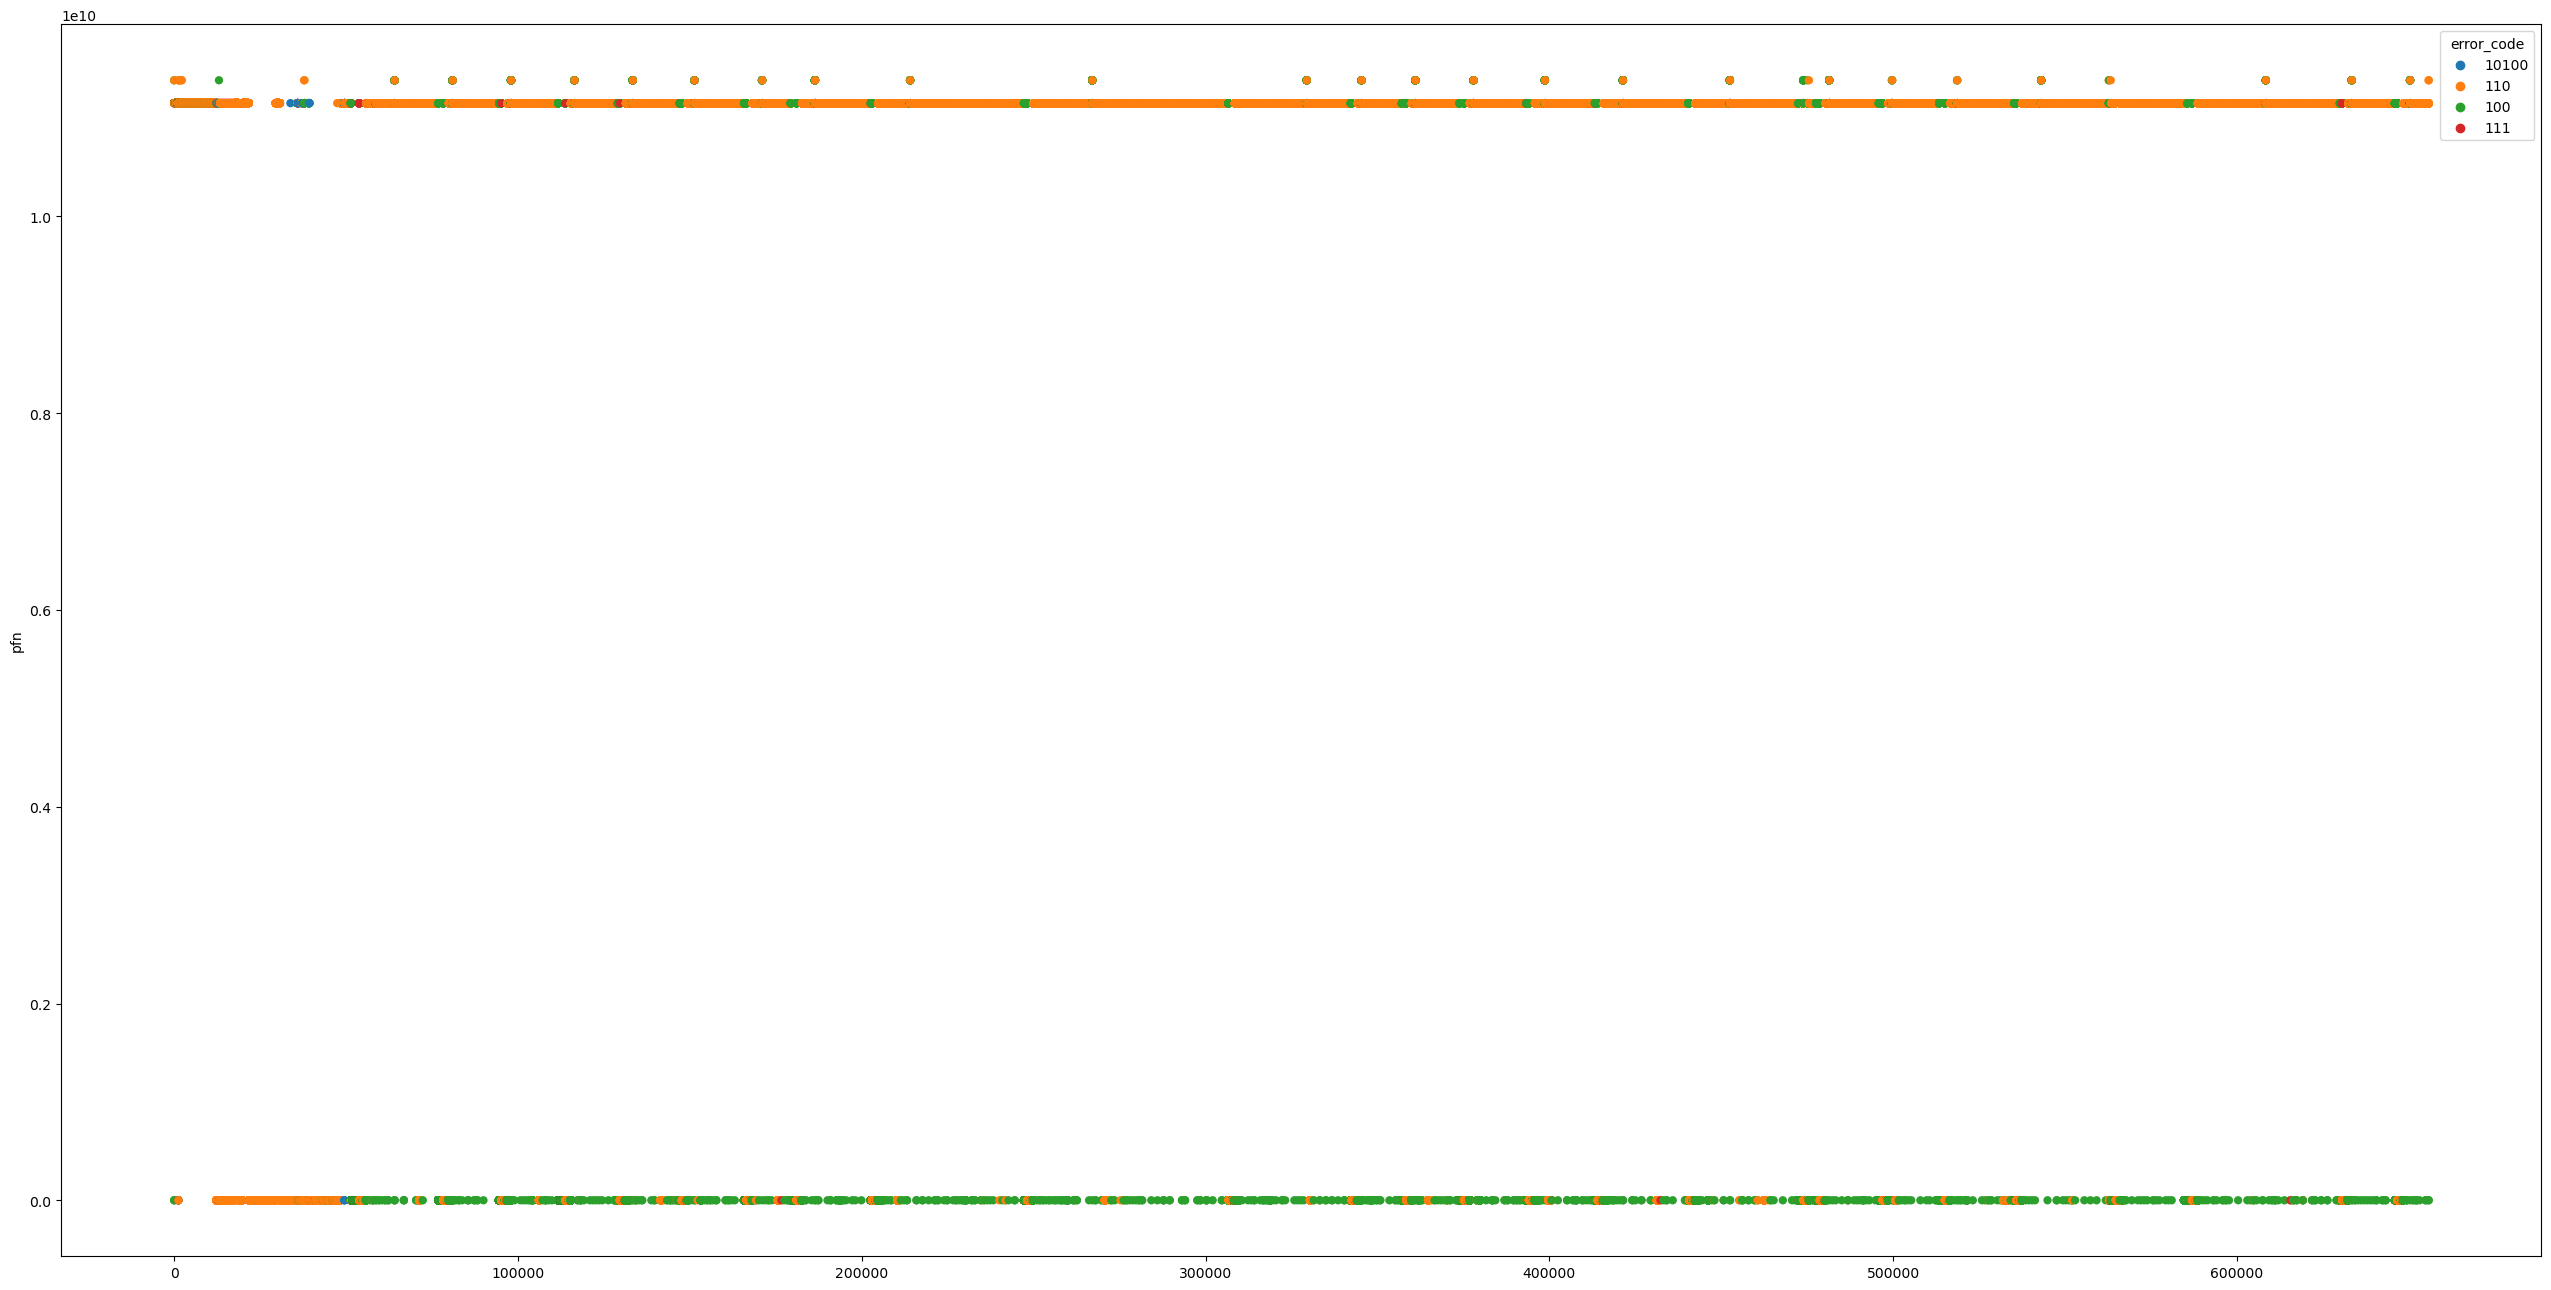

In [12]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(df)), y=df['pfn'], hue=df["error_code"], linewidth=0)

In [13]:
kernel_fault = df[df["pfn"] > 0.6e10]
user_fault = df[df["pfn"] <= 0.6e10]

<Axes: ylabel='pfn'>

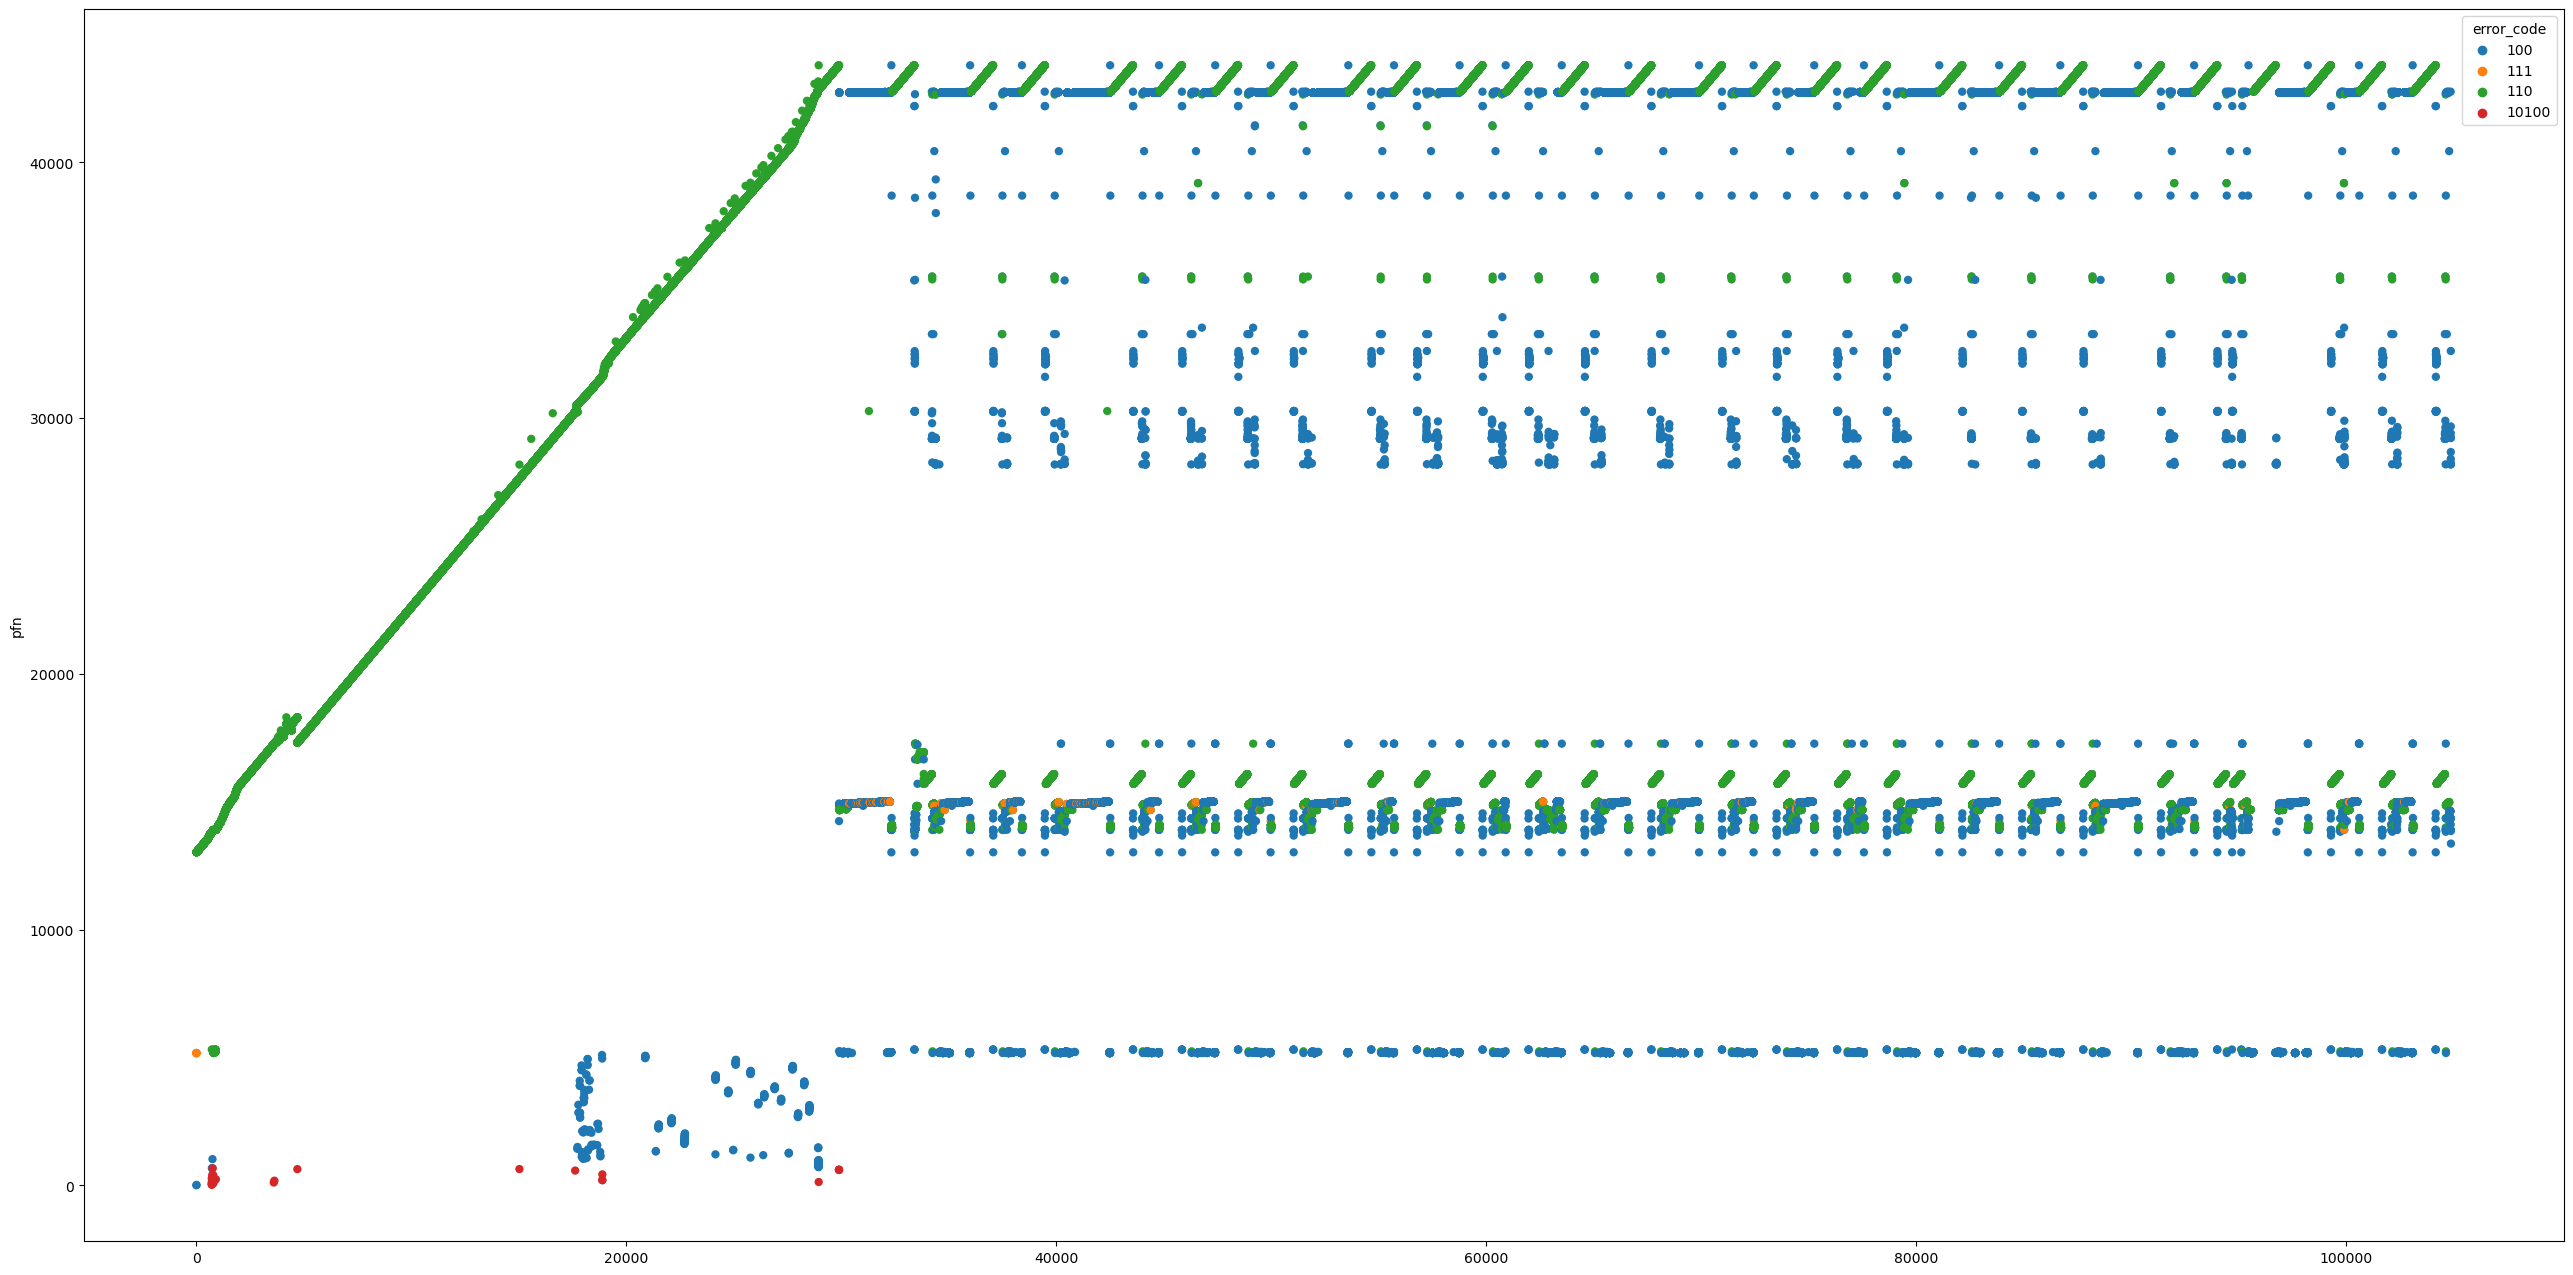

In [14]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(user_fault)), y=user_fault['pfn'], hue=user_fault["error_code"], linewidth=0)